# Propensity score stratifiering 

Denna notebook implementerar propensity score (PS)-baserad stratifiering för att balansera grupperna
CCI ≤ 5 (kontroll) och CCI > 5 (behandling). PS skattas med logistisk regression baserat på ålder,
kön och laboratorievärden (glukos, natrium samt log1p-transformerade njurmarkörer BUN och kreatinin).
Balans utvärderas med SMD före och efter stratifiering. Mortalitet rapporteras som rå risk och
strata-standardiserad risk för 30, 90 och 365 dagar.


In [1]:
import sys, os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm 

In [2]:
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)
from src.connect_db import run_query, close_tunnel

# --- Läs in basdata (kohort) ---
sql_path = PROJECT_ROOT / "sql" / "stroke_cci_ps_cohort.sql"
with open(sql_path, encoding="utf-8") as f:
    cohort_sql = f.read()

df_base = run_query(cohort_sql)
print("df_base kolumner:", df_base.columns.tolist())
print("df_base antal rader:", len(df_base))

# --- Läs in kovariater (första 24h) ---
sql_path = PROJECT_ROOT / "sql" / "stroke_covariates_first24h.sql"
with open(sql_path, encoding="utf-8") as f:
    cov_sql = f.read()

df_cov = run_query(cov_sql)
print("df_cov kolumner:", df_cov.columns.tolist())
print("df_cov antal rader:", len(df_cov))

PROJECT_ROOT = C:\Users\enaam\exjobb


c:\Users\enaam\.conda\envs\mimicenv\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\enaam\.conda\envs\mimicenv\Lib\site-packages\paramiko\transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,
2026-02-03 14:19:02,599| ERROR   | Password is required for key C:\Users\enaam/.ssh\id_rsa


SSH-tunnel startad på lokal port: 57598
df_base kolumner: ['subject_id', 'hadm_id', 'admittime', 'gender', 'anchor_age', 'dod', 'died', 'died_30d', 'died_90d', 'died_1y', 'cci_score', 'high_cci']
df_base antal rader: 4747
df_cov kolumner: ['subject_id', 'hadm_id', 'admittime', 'anchor_age', 'gender', 'creatinine_first', 'glucose_first', 'sodium_first', 'bun_first', 'bun_cr_ratio_first', 'has_creatinine', 'has_glucose', 'has_sodium', 'has_bun']
df_cov antal rader: 4747


### Baslinje: gruppstorlek och mortalitet före balansering

In [3]:
# Säkerställ att outcome-kolumnerna är 0/1 (ibland kommer bool)
outcome_cols = ["died", "died_30d", "died_90d", "died_1y"]
for c in outcome_cols:
    if c in df_base.columns and df_base[c].dtype == "bool":
        df_base[c] = df_base[c].astype(int)

# Antal döda per CCI-grupp (0=CCI≤5, 1=CCI>5)
counts = df_base.groupby("high_cci")[outcome_cols].sum().astype(int)
counts.index = counts.index.map({0: "CCI ≤ 5", 1: "CCI > 5"})

# Totalt antal patienter per grupp
counts["n_patients"] = df_base.groupby("high_cci").size().astype(int).values

# Snygg ordning
counts = counts[["n_patients", "died", "died_30d", "died_90d", "died_1y"]]
display(counts)

,n_patients,died,died_30d,died_90d,died_1y
high_cci,,,,,
CCI ≤ 5,4100,1259,563,780,1042
CCI > 5,647,384,164,228,321


## Datakvalitet: duplikat och saknade värden


In [4]:
# Duplikatkontroll
dup_base = df_base.duplicated(subset=["hadm_id"]).sum() if "hadm_id" in df_base.columns else np.nan
dup_cov  = df_cov.duplicated(subset=["hadm_id"]).sum()  if "hadm_id" in df_cov.columns else np.nan
print("Duplikat hadm_id i df_base:", dup_base)
print("Duplikat hadm_id i df_cov:", dup_cov)

# Missingness i labb
lab_cols = ["creatinine_first","glucose_first","sodium_first","bun_first"]
print("\nMissingness (antal NaN) i df_cov:")
display(df_cov[lab_cols].isna().sum())

print("\nSanity check describe (df_cov):")
show_cols = ["anchor_age"] + lab_cols
show_cols = [c for c in show_cols if c in df_cov.columns]
display(df_cov[show_cols].describe())


Duplikat hadm_id i df_base: 0
Duplikat hadm_id i df_cov: 0

Missingness (antal NaN) i df_cov:


creatinine_first    445
glucose_first       470
sodium_first        456
bun_first           446
dtype: int64


Sanity check describe (df_cov):


,anchor_age,creatinine_first,glucose_first,sodium_first,bun_first
count,4747.000000,4302.000000,4277.000000,4291.000000,4301.000000
mean,67.514430,1.233101,135.494038,139.308553,21.627993
std,14.720416,1.231838,66.951620,4.215729,16.183460
min,18.000000,0.200000,31.000000,113.000000,3.000000
25%,58.000000,0.700000,96.000000,137.000000,13.000000
50%,69.000000,0.900000,115.000000,139.000000,17.000000
75%,79.000000,1.200000,151.000000,142.000000,24.000000
max,91.000000,18.200000,1267.000000,167.000000,189.000000


## Sammanfogning av basdata och kovariater


In [5]:
# Undvik dubbla demografikolumner genom att bara ta labb från df_cov
lab_keep = ["hadm_id","creatinine_first","glucose_first","sodium_first","bun_first"]
missing_keep = [c for c in lab_keep if c not in df_cov.columns]
if missing_keep:
    raise ValueError(f"Saknar kolumner i df_cov: {missing_keep}")

df_ps = df_base.merge(df_cov[lab_keep], on="hadm_id", how="left")

if "gender" not in df_ps.columns:
    raise ValueError("Saknar 'gender' i df_ps efter merge. Kontrollera df_base.")

df_ps["is_male"] = (df_ps["gender"] == "M").astype(int)

print("df_ps antal rader:", len(df_ps))
print("\nNaN i labb efter merge:")
display(df_ps[["creatinine_first","glucose_first","sodium_first","bun_first"]].isna().sum())


df_ps antal rader: 4747

NaN i labb efter merge:


creatinine_first    445
glucose_first       470
sodium_first        456
bun_first           446
dtype: int64

## Hantering av saknade labbvärden och log-transform

Saknade labbvärden hanteras med medianimputering per variabel innan PS skattas, för att undvika
bortfall av observationer. Kreatinin och BUN log-transformeras med log1p för att minska påverkan
av snedfördelning och extremvärden.


In [6]:
lab_cols = ["creatinine_first","glucose_first","sodium_first","bun_first"]

# Medianimputering per labbvariabel
for c in lab_cols:
    df_ps[c] = df_ps[c].astype(float)
    df_ps[c] = df_ps[c].fillna(df_ps[c].median(skipna=True))

# log-transform för njurmarkörer
df_ps["log_bun"] = np.log1p(df_ps["bun_first"])
df_ps["log_creatinine"] = np.log1p(df_ps["creatinine_first"])

print("NaN kvar i labb (ska vara 0):", int(df_ps[lab_cols].isna().sum().sum()))


NaN kvar i labb (ska vara 0): 0


## Skattning av propensity score och stratifiering (10 strata)

PS skattas med logistisk regression där behandlingsindikatorn är high_cci (1=CCI>5, 0=CCI≤5).
Individer delas in i 10 strata via kvantilindelning av PS.

In [7]:
use_covars_log = ["anchor_age","is_male","log_creatinine","glucose_first","sodium_first","log_bun"]

missing_cov = [c for c in use_covars_log if c not in df_ps.columns]
if missing_cov:
    raise ValueError(f"Saknar kovariater i df_ps: {missing_cov}")

X = df_ps[use_covars_log].astype(float).copy()
X = X.replace([np.inf, -np.inf], np.nan)
for c in X.columns:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

y = df_ps["high_cci"].astype(int).values

clf = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000)
clf.fit(X.values, y)

df_ps["ps_log"] = clf.predict_proba(X.values)[:, 1]
df_ps["ps_stratum10_log"] = pd.qcut(df_ps["ps_log"], q=10, labels=False, duplicates="drop")

print("ps_log min/max:", float(df_ps["ps_log"].min()), float(df_ps["ps_log"].max()))
display(pd.crosstab(df_ps["ps_stratum10_log"], df_ps["high_cci"]))


ps_log min/max: 0.014925410067553276 0.9535199635655462


high_cci,0,1
ps_stratum10_log,,
0,460,15
1,454,21
2,453,21
3,454,21
4,438,44
5,427,40
6,413,62
7,385,89
8,345,130


### Baslinje före balansering (N, medel/andel, SMD)

In [8]:
# Baslinje före balansering
vars_base = ["anchor_age","is_male","bun_first","creatinine_first","glucose_first","sodium_first"]

# säkerställ att df_ps finns (efter merge) och att is_male finns
need = ["high_cci"] + vars_base
miss = [c for c in need if c not in df_ps.columns]
if miss:
    raise ValueError(f"Saknar kolumner i df_ps: {miss}")

def smd_cont(a, b):
    a = np.asarray(a); b = np.asarray(b)
    sp = np.sqrt((a.var(ddof=1) + b.var(ddof=1)) / 2)
    return (a.mean() - b.mean()) / sp if sp > 0 else np.nan

def smd_bin(a, b):
    a = np.asarray(a); b = np.asarray(b)
    p = (a.mean() + b.mean()) / 2
    sp = np.sqrt(p * (1 - p))
    return (a.mean() - b.mean()) / sp if sp > 0 else np.nan

t = df_ps[df_ps["high_cci"]==1]
c = df_ps[df_ps["high_cci"]==0]

rows = []
for v in vars_base:
    mean_c = float(c[v].mean())
    mean_t = float(t[v].mean())
    smd = smd_bin(t[v], c[v]) if v=="is_male" else smd_cont(t[v], c[v])
    rows.append([v, mean_c, mean_t, float(smd)])

tab_baseline = pd.DataFrame(rows, columns=["Variabel","Kontroll (CCI≤5)","Behandling (CCI>5)","SMD_pre"])
display(tab_baseline)


,Variabel,Kontroll (CCI≤5),Behandling (CCI>5),SMD_pre
0,anchor_age,67.235122,69.284389,0.147948
1,is_male,0.500244,0.556414,0.112521
2,bun_first,19.389512,32.622875,0.707298
3,creatinine_first,1.082951,1.955487,0.599960
4,glucose_first,130.679268,151.117465,0.285515
5,sodium_first,139.337317,138.908810,-0.102609


### Mortalitet före (antal + andel)

In [9]:
# Mortalitet före balansering
outcomes = ["died_30d","died_90d","died_1y"]

rows = []
for oc in outcomes:
    d = df_ps.dropna(subset=[oc, "high_cci"]).copy()
    n0 = int((d["high_cci"]==0).sum())
    n1 = int((d["high_cci"]==1).sum())
    dead0 = int(d.loc[d["high_cci"]==0, oc].sum())
    dead1 = int(d.loc[d["high_cci"]==1, oc].sum())
    rows.append([oc, n0, dead0, 100*dead0/n0, n1, dead1, 100*dead1/n1])

tab_mort_pre = pd.DataFrame(
    rows,
    columns=["Outcome","N_kontroll","Döda_kontroll","%_kontroll","N_behandling","Döda_behandling","%_behandling"]
)
tab_mort_pre[["%_kontroll","%_behandling"]] = tab_mort_pre[["%_kontroll","%_behandling"]].round(1)
display(tab_mort_pre)


,Outcome,N_kontroll,Döda_kontroll,%_kontroll,N_behandling,Döda_behandling,%_behandling
0,died_30d,4100,563,13.7,647,164,25.3
1,died_90d,4100,780,19.0,647,228,35.2
2,died_1y,4100,1042,25.4,647,321,49.6


## Kovariatbalans: SMD före och efter PS-stratifiering

SMD beräknas före justering samt efter stratifiering genom att summera stratum-specifika SMD
viktat med stratumstorlek.


In [10]:
def smd_cont(a, b):
    a = np.asarray(a); b = np.asarray(b)
    sp = np.sqrt((a.var(ddof=1) + b.var(ddof=1)) / 2)
    return (a.mean() - b.mean()) / sp if sp > 0 else np.nan

def smd_bin(a, b):
    a = np.asarray(a); b = np.asarray(b)
    p = (a.mean() + b.mean()) / 2
    sp = np.sqrt(p * (1 - p))
    return (a.mean() - b.mean()) / sp if sp > 0 else np.nan

balance_vars = ["anchor_age","is_male","creatinine_first","glucose_first","sodium_first","bun_first"]

t = df_ps[df_ps["high_cci"]==1]
c = df_ps[df_ps["high_cci"]==0]

pre = {v: (smd_bin(t[v], c[v]) if v=="is_male" else smd_cont(t[v], c[v])) for v in balance_vars}

post = {}
strata = sorted(df_ps["ps_stratum10_log"].dropna().unique())
for v in balance_vars:
    smds=[]; w=[]
    for s in strata:
        dss = df_ps[df_ps["ps_stratum10_log"]==s]
        t_s = dss[dss["high_cci"]==1]
        c_s = dss[dss["high_cci"]==0]
        if len(t_s)==0 or len(c_s)==0:
            continue
        smd_s = smd_bin(t_s[v], c_s[v]) if v=="is_male" else smd_cont(t_s[v], c_s[v])
        smds.append(smd_s); w.append(len(dss))
    post[v] = np.average(smds, weights=w) if len(smds)>0 else np.nan

df_smd_log = pd.DataFrame({
    "SMD_pre": pd.Series(pre),
    "SMD_post_10strata_logPS": pd.Series(post)
})
df_smd_log["|SMD_pre|"] = df_smd_log["SMD_pre"].abs()
df_smd_log["|SMD_post_10strata_logPS|"] = df_smd_log["SMD_post_10strata_logPS"].abs()

display(df_smd_log.sort_values("|SMD_pre|", ascending=False))
print("Max |SMD_post_10strata_logPS|:", float(df_smd_log["|SMD_post_10strata_logPS|"].max()))

,SMD_pre,SMD_post_10strata_logPS,|SMD_pre|,|SMD_post_10strata_logPS|
bun_first,0.707298,-0.117246,0.707298,0.117246
creatinine_first,0.599960,0.160632,0.599960,0.160632
glucose_first,0.285515,-0.022863,0.285515,0.022863
anchor_age,0.147948,0.010396,0.147948,0.010396
is_male,0.112521,-0.022326,0.112521,0.022326
sodium_first,-0.102609,-0.007757,0.102609,0.007757


Max |SMD_post_10strata_logPS|: 0.16063179350940193


## Utfall: mortalitet före och efter PS-stratifiering (strata-standardiserad risk)

Efter PS-stratifiering beräknas strata-standardiserad risk genom att vikta stratum-specifika risker
med den totala stratafördelningen i kohorten. Detta ger en jämförbar mortalitetsandel för grupperna.


,Outcome,Typ,Risk_low,Risk_high
0,died_30d,Före (rå),0.137317,0.253478
1,died_30d,Efter (PS-strata std),0.147703,0.221598
2,died_90d,Före (rå),0.190244,0.352396
3,died_90d,Efter (PS-strata std),0.203963,0.305935
4,died_1y,Före (rå),0.254146,0.496136
5,died_1y,Efter (PS-strata std),0.271663,0.432494


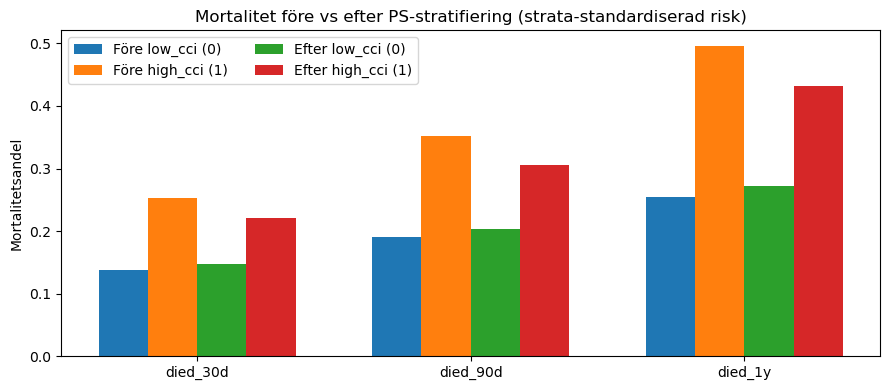

,Outcome,RD_pre,RD_post
0,died_30d,0.116161,0.073895
1,died_90d,0.162152,0.101973
2,died_1y,0.241990,0.160831


In [11]:
strata_col = "ps_stratum10_log"
outcomes = ["died_30d", "died_90d", "died_1y"]

def standardized_risk(d, outcome_col, group_value, strata_col):
    strata_weights = d[strata_col].value_counts(normalize=True).sort_index()
    parts = []
    for s, w in strata_weights.items():
        ds = d[d[strata_col] == s]
        r = ds.loc[ds["high_cci"] == group_value, outcome_col].mean()
        if pd.isna(r):
            continue
        parts.append(w * float(r))
    return float(np.sum(parts))

rows = []
for oc in outcomes:
    d = df_ps.dropna(subset=[oc, "high_cci", strata_col]).copy()
    d["high_cci"] = d["high_cci"].astype(int)
    d[oc] = d[oc].astype(int)
    d[strata_col] = d[strata_col].astype(int)

    # Före (rå risk)
    pre = d.groupby("high_cci")[oc].mean()
    pre0, pre1 = float(pre.loc[0]), float(pre.loc[1])

    # Efter (strata-standardiserad risk)
    post0 = standardized_risk(d, oc, 0, strata_col)
    post1 = standardized_risk(d, oc, 1, strata_col)

    rows.append([oc, "Före (rå)", pre0, pre1])
    rows.append([oc, "Efter (PS-strata std)", post0, post1])

df_plot = pd.DataFrame(rows, columns=["Outcome", "Typ", "Risk_low", "Risk_high"])
display(df_plot)

# --- Plot: grupperade staplar ---
x = np.arange(len(outcomes))
width = 0.18

pre_low  = df_plot[df_plot["Typ"]=="Före (rå)"]["Risk_low"].values
pre_high = df_plot[df_plot["Typ"]=="Före (rå)"]["Risk_high"].values
post_low = df_plot[df_plot["Typ"]=="Efter (PS-strata std)"]["Risk_low"].values
post_high= df_plot[df_plot["Typ"]=="Efter (PS-strata std)"]["Risk_high"].values

plt.figure(figsize=(9,4))
plt.bar(x - 1.5*width, pre_low,  width=width, label="Före low_cci (0)")
plt.bar(x - 0.5*width, pre_high, width=width, label="Före high_cci (1)")
plt.bar(x + 0.5*width, post_low, width=width, label="Efter low_cci (0)")
plt.bar(x + 1.5*width, post_high,width=width, label="Efter high_cci (1)")
plt.xticks(x, outcomes)
plt.ylabel("Mortalitetsandel")
plt.title("Mortalitet före vs efter PS-stratifiering (strata-standardiserad risk)")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

# --- Sammanfattning: riskdifferens före/efter ---
summary = []
for i, oc in enumerate(outcomes):
    rd_pre  = pre_high[i] - pre_low[i]
    rd_post = post_high[i] - post_low[i]
    summary.append([oc, rd_pre, rd_post])

df_summary = pd.DataFrame(summary, columns=["Outcome", "RD_pre", "RD_post"])
display(df_summary)


## Appendix: Diagnostikfigurer

Detta avsnitt innehåller kompletterande visualiseringar av kovariatbalans.


### SMD-plot före/efter

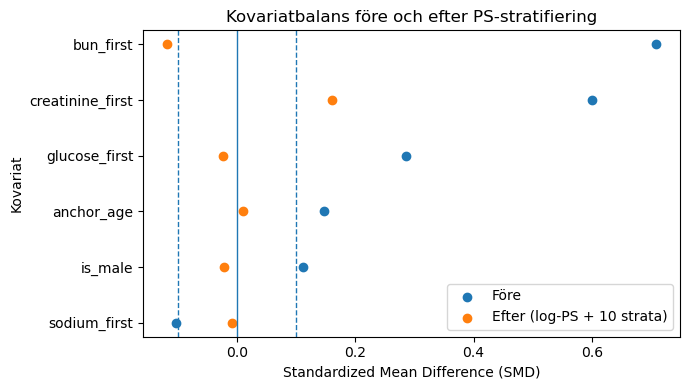

In [12]:
tmp = df_smd_log.copy().sort_values("|SMD_pre|", ascending=True)

plt.figure(figsize=(7,4))
plt.scatter(tmp["SMD_pre"], tmp.index, label="Före")
plt.scatter(tmp["SMD_post_10strata_logPS"], tmp.index, label="Efter (log-PS + 10 strata)")
plt.axvline(0, linewidth=1)
plt.axvline(0.1, linestyle="--", linewidth=1)
plt.axvline(-0.1, linestyle="--", linewidth=1)
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Kovariat")
plt.title("Kovariatbalans före och efter PS-stratifiering")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Efter PS-stratifiering (strata-standardiserade medel + SMD_post)
strata_col = "ps_stratum10_log"
group_col = "high_cci"
vars_show = ["anchor_age","is_male","bun_first","creatinine_first","glucose_first","sodium_first"]

need = [strata_col, group_col] + vars_show
miss = [c for c in need if c not in df_ps.columns]
if miss:
    raise ValueError(f"Saknar kolumner i df_ps: {miss}")

d = df_ps.dropna(subset=[strata_col, group_col]).copy()
d[strata_col] = d[strata_col].astype(int)
d[group_col] = d[group_col].astype(int)

# strata-vikter = stratafördelning i HELA kohorten (standardiseringsmål)
w_strata = d[strata_col].value_counts(normalize=True).sort_index()

def std_mean(var, gval):
    parts = []
    for s, w in w_strata.items():
        ds = d[d[strata_col]==s]
        m = ds.loc[ds[group_col]==gval, var].mean()
        if pd.isna(m):
            continue
        parts.append(w * float(m))
    return float(np.sum(parts))

# SMD_post från din tidigare df_smd_log
# df_smd_log måste finnas från din SMD-cell
if "df_smd_log" not in globals():
    raise ValueError("df_smd_log saknas. Kör cellen där du beräknar SMD före/efter först.")

rows = []
for v in vars_show:
    m0 = std_mean(v, 0)
    m1 = std_mean(v, 1)
    smd_post = float(df_smd_log.loc[v, "SMD_post_10strata_logPS"]) if v in df_smd_log.index else np.nan
    rows.append([v, m0, m1, smd_post])

tab_post = pd.DataFrame(rows, columns=["Variabel","Kontroll (std)","Behandling (std)","SMD_efter"])
display(tab_post)


,Variabel,Kontroll (std),Behandling (std),SMD_efter
0,anchor_age,67.729592,67.810540,0.010396
1,is_male,0.508308,0.497646,-0.022326
2,bun_first,21.168069,21.001039,-0.117246
3,creatinine_first,1.184081,1.251921,0.160632
4,glucose_first,133.173835,133.115816,-0.022863
5,sodium_first,139.300678,139.208743,-0.007757


In [14]:
# === Tabell C: Mortalitet före vs efter (PS-strata standardiserad risk) ===

strata_col = "ps_stratum10_log"
outcomes = ["died_30d","died_90d","died_1y"]

def standardized_risk(d, outcome_col, group_value, strata_col):
    strata_weights = d[strata_col].value_counts(normalize=True).sort_index()
    parts = []
    for s, w in strata_weights.items():
        ds = d[d[strata_col]==s]
        r = ds.loc[ds["high_cci"]==group_value, outcome_col].mean()
        if pd.isna(r):
            continue
        parts.append(w * float(r))
    return float(np.sum(parts))

rows = []
for oc in outcomes:
    dd = df_ps.dropna(subset=[oc, "high_cci", strata_col]).copy()
    dd["high_cci"] = dd["high_cci"].astype(int)
    dd[oc] = dd[oc].astype(int)
    dd[strata_col] = dd[strata_col].astype(int)

    # Gruppstorlekar
    n0 = int((dd["high_cci"]==0).sum())
    n1 = int((dd["high_cci"]==1).sum())

    # Före (rå risk)
    pre = dd.groupby("high_cci")[oc].mean()
    pre0, pre1 = float(pre.loc[0]), float(pre.loc[1])

    # Efter (strata-standardiserad risk)
    post0 = standardized_risk(dd, oc, 0, strata_col)
    post1 = standardized_risk(dd, oc, 1, strata_col)

    # (valfritt) expected deaths efter standardisering
    exp_dead0 = post0 * n0
    exp_dead1 = post1 * n1

    rows.append([
        oc,
        n0, 100*pre0, 100*post0, exp_dead0,
        n1, 100*pre1, 100*post1, exp_dead1
    ])

tab_mort_post = pd.DataFrame(
    rows,
    columns=[
        "Outcome",
        "N_kontroll", "%_före_kontroll", "%_efter_std_kontroll", "Döda_exp_efter_kontroll",
        "N_behandling", "%_före_behandling", "%_efter_std_behandling", "Döda_exp_efter_behandling"
    ]
)

tab_mort_post[["%_före_kontroll","%_efter_std_kontroll","%_före_behandling","%_efter_std_behandling"]] = \
    tab_mort_post[["%_före_kontroll","%_efter_std_kontroll","%_före_behandling","%_efter_std_behandling"]].round(1)

tab_mort_post[["Döda_exp_efter_kontroll","Döda_exp_efter_behandling"]] = \
    tab_mort_post[["Döda_exp_efter_kontroll","Döda_exp_efter_behandling"]].round(1)

display(tab_mort_post)


,Outcome,N_kontroll,%_före_kontroll,%_efter_std_kontroll,Döda_exp_efter_kontroll,N_behandling,%_före_behandling,%_efter_std_behandling,Döda_exp_efter_behandling
0,died_30d,4100,13.7,14.8,605.6,647,25.3,22.2,143.4
1,died_90d,4100,19.0,20.4,836.2,647,35.2,30.6,197.9
2,died_1y,4100,25.4,27.2,1113.8,647,49.6,43.2,279.8
